In [101]:
#%% import les bibliothèques
import pandas as pd
import numpy as np
import gc # Pour la gestion de la mémoire
import os
import sklearn as skl

In [102]:
#%% importer les tables 
len(os.listdir("./data"))


9

In [103]:

os.listdir('./data')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv']

In [104]:
# Charger les données de base
train_df = pd.read_csv('data/application_train.csv')
test_df = pd.read_csv('data/application_test.csv')

# Ajouter un marqueur pour les séparer plus tard
train_df['is_train'] = 1
test_df['is_train'] = 0

# Concaténer
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [105]:
#%% --- FONCTION UTILITAIRE : Encodage ---
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [106]:
#%% --- 1. TRAITEMENT : BUREAU & BUREAU_BALANCE ---
def process_bureau_and_balance(path, nan_as_category=True):
    bureau = pd.read_csv(f'{path}/bureau.csv')
    bb = pd.read_csv(f'{path}/bureau_balance.csv')
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Agrégation de Bureau Balance
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    
    # Agrégation de Bureau vers Application
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum']
    }
    
    cat_aggregations = {}
    for col in bureau_cat: cat_aggregations[col] = ['mean']
    for col in bb_cat: cat_aggregations[col + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    return bureau_agg

In [107]:

#%% --- 2. TRAITEMENT : PREVIOUS APPLICATIONS ---
def process_previous_applications(path, nan_as_category=True):
    prev = pd.read_csv(f'{path}/previous_application.csv')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    # remplacement des valeurs aberrantes 
    prev['DAYS_FIRST_DRAWING'] = prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan)
    prev['DAYS_FIRST_DUE'] = prev['DAYS_FIRST_DUE'].replace(365243, np.nan)
    
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    cat_aggregations = {}
    for col in cat_cols: cat_aggregations[col] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    return prev_agg


In [108]:

#%% --- 3. TRAITEMENT : COMPORTEMENT (POS, INSTALLMENTS, CREDIT CARD) ---
def process_behavioral_data(path, nan_as_category=True):
    # POS_CASH_balance
    pos = pd.read_csv(f'{path}/POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    pos_agg = pos.groupby('SK_ID_CURR').agg({'MONTHS_BALANCE': ['max', 'mean', 'size'], 'SK_DPD': ['max', 'mean']})
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Installments_payments
    ins = pd.read_csv(f'{path}/installments_payments.csv')
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT'] # Jours de retard
    ins_agg = ins.groupby('SK_ID_CURR').agg({'DPD': ['max', 'mean', 'sum'], 'PAYMENT_PERC': ['mean', 'sum'], 'AMT_PAYMENT': ['min', 'max', 'mean', 'sum']})
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    return pos_agg.join(ins_agg, how='outer', on='SK_ID_CURR')


In [109]:

#%% --- FONCTION PRINCIPALE DE FUSION ---
def main_data_pipeline(path):
    print("Chargement de la table principale...")
    df = pd.read_csv(f'{path}/application_train.csv')
    # Charger les données de base
    train_df = pd.read_csv('data/application_train.csv')
    test_df = pd.read_csv('data/application_test.csv')

    # Ajouter un marqueur pour les séparer plus tard
    train_df['is_train'] = 1
    test_df['is_train'] = 0

# Concaténer
    full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    df, _ = one_hot_encoder(full_df)
    
    # 1. Fusion Bureau (Remplacement de .join par .merge)
    print("Fusion Bureau...")
    bureau_data = process_bureau_and_balance(path)
    df = pd.merge(df, bureau_data, on='SK_ID_CURR', how='left')
    
    # 2. Fusion Previous Apps
    print("Fusion Previous Apps...")
    prev_data = process_previous_applications(path)
    df = pd.merge(df, prev_data, on='SK_ID_CURR', how='left')
    
    # 3. Fusion Comportementale
    print("Fusion Comportementale...")
    behavior_data = process_behavioral_data(path)
    df = pd.merge(df, behavior_data, on='SK_ID_CURR', how='left')
    
    print(f"Dataset prêt. Taille finale : {df.shape}")
    return df

#%% --- EXECUTION ---
dataset = main_data_pipeline('./data')
gc.collect()



Chargement de la table principale...
Fusion Bureau...
Fusion Previous Apps...
Fusion Comportementale...
Dataset prêt. Taille finale : (356255, 507)


263690

In [110]:
# Retrouver le set d'entraînement (avec la TARGET)
df = full_df[full_df['is_train'] == 1].drop(columns=['is_train'])

# Retrouver le set de test (pour la prédiction finale)
test_df = full_df[full_df['is_train'] == 0].drop(columns=['is_train', 'TARGET'])

--- Analyse de la Cible (TARGET) ---
Classe 0 (Remboursé) : 282686 individus (91.93%)
Classe 1 (Défaillant) : 24825 individus (8.07%)
Ratio de déséquilibre : 1 pour 11


/var/folders/dr/qtbb25gd2pl7ssnx51bqxv6r0000gp/T/ipykernel_3277/1174154582.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='TARGET', data=df, palette='Set2')


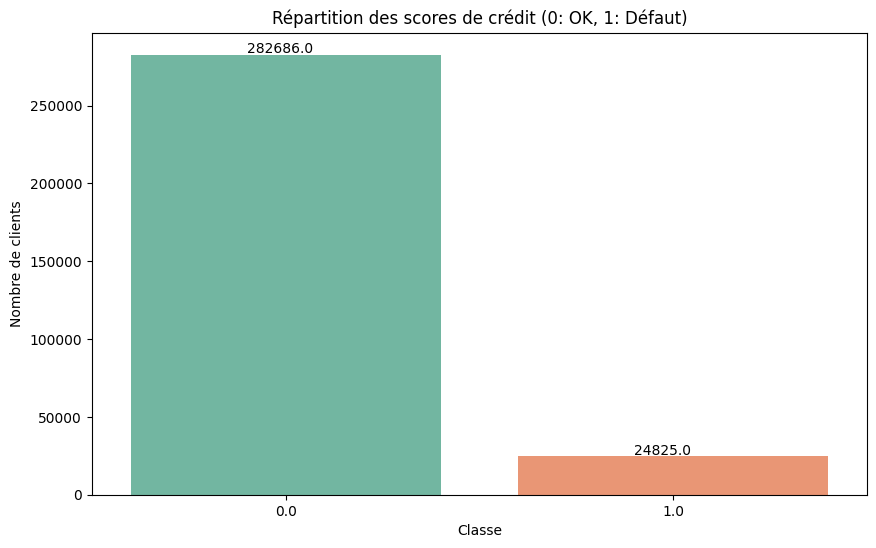

In [111]:

#%% ANALYZE TARGET
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_target(df):
    # Calcul des proportions
    target_counts = df['TARGET'].value_counts()
    target_percent = df['TARGET'].value_counts(normalize=True) * 100
    
    print("--- Analyse de la Cible (TARGET) ---")
    print(f"Classe 0 (Remboursé) : {target_counts[0]} individus ({target_percent[0]:.2f}%)")
    print(f"Classe 1 (Défaillant) : {target_counts[1]} individus ({target_percent[1]:.2f}%)")
    print(f"Ratio de déséquilibre : 1 pour {int(target_counts[0]/target_counts[1])}")
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='TARGET', data=df, palette='Set2')
    
    # Ajout des pourcentages sur les barres
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()+0.3, p.get_height()+1000))
        
    plt.title('Répartition des scores de crédit (0: OK, 1: Défaut)')
    plt.xlabel('Classe')
    plt.ylabel('Nombre de clients')
    plt.show()
#%%
analyze_target(dataset)
# %%



In [112]:
# Calculer le taux de valeurs manquantes par colonne
missing_rate = dataset.isnull().mean() * 100
columns_to_drop = missing_rate[missing_rate > 70].index # Seuil de 70% par exemple
print(f"Nombre de colonnes avec > 70% de vide : {len(columns_to_drop)}")

Nombre de colonnes avec > 70% de vide : 0


In [113]:
# analyse des valeurs manquantes et corrélation
import pandas as pd
import numpy as np

def final_data_cleaning(df, missing_threshold=70):
    print(f"--- Nettoyage final du dataset ({df.shape[1]} colonnes) ---")
    
    # 1. Analyse des valeurs manquantes
    missing_stats = df.isnull().mean() * 100
    cols_to_drop = missing_stats[missing_stats > missing_threshold].index.tolist()
    
    print(f"Suppression de {len(cols_to_drop)} colonnes ayant plus de {missing_threshold}% de vide.")
    df_cleaned = df.drop(columns=cols_to_drop)
    
    # 2. Gestion des corrélations (Exploration des données)
    # On regarde quelles variables sont les plus liées à la TARGET
    correlations = df_cleaned.corr()['TARGET'].sort_values()
    
    print("\nTop 5 des corrélations négatives (Facteurs de protection) :")
    print(correlations.head(5))
    
    print("\nTop 5 des corrélations positives (Facteurs de risque) :")
    print(correlations.tail(6)) # tail(6) car la dernière est TARGET elle-même (1.0)
    
    # 3. Vérification des formats
    # On remplace les colonnes à valeurs infinies (souvent dues aux divisions par 0 dans le FE)
    df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 4. Suppression des colonnes avec une seule valeur unique (inutiles pour le modèle)
    unique_cols = [col for col in df_cleaned.columns if df_cleaned[col].nunique() <= 1]
    print(f"\nSuppression de {len(unique_cols)} colonnes ayant une valeur unique ou moins.")
    df_cleaned.drop(columns=unique_cols, inplace=True)
    
    print(f"\nNettoyage terminé. Dataset final : {df_cleaned.shape}")
    return df_cleaned

# Utilisation :
dataset_final = final_data_cleaning(dataset)

--- Nettoyage final du dataset (507 colonnes) ---
Suppression de 0 colonnes ayant plus de 70% de vide.

Top 5 des corrélations négatives (Facteurs de protection) :
EXT_SOURCE_3                       -0.178919
EXT_SOURCE_2                       -0.160472
EXT_SOURCE_1                       -0.155317
BURO_CREDIT_ACTIVE_Closed_MEAN     -0.079369
PREV_CODE_REJECT_REASON_XAP_MEAN   -0.073930
Name: TARGET, dtype: float64

Top 5 des corrélations positives (Facteurs de risque) :
PREV_NAME_GOODS_CATEGORY_nan_MEAN    NaN
PREV_NAME_PORTFOLIO_nan_MEAN         NaN
PREV_NAME_PRODUCT_TYPE_nan_MEAN      NaN
PREV_CHANNEL_TYPE_nan_MEAN           NaN
PREV_NAME_SELLER_INDUSTRY_nan_MEAN   NaN
PREV_NAME_YIELD_GROUP_nan_MEAN       NaN
Name: TARGET, dtype: float64

Suppression de 28 colonnes ayant une valeur unique ou moins.

Nettoyage terminé. Dataset final : (356255, 479)


In [114]:
def remove_highly_correlated_features(df, threshold=0.9):
    # On ne calcule la corrélation que sur les variables explicatives (pas la TARGET)
    df_features = df.drop(columns=['TARGET']) if 'TARGET' in df.columns else df
    
    # Calcul de la matrice de corrélation
    corr_matrix = df_features.corr().abs()
    
    # Sélection du triangle supérieur de la matrice (pour éviter les doublons A-B et B-A)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identification des colonnes à supprimer
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Nombre de colonnes avec une corrélation > {threshold}: {len(to_drop)}")
    print(f"Exemples de colonnes supprimées : {to_drop[:10]}")
    
    df_reduced = df.drop(columns=to_drop)
    print(f"Nouveau nombre de variables : {df_reduced.shape[1]}")
    
    return df_reduced

# Utilisation avec un seuil de 0.9 (90% de corrélation)
dataset_final = remove_highly_correlated_features(dataset_final, threshold=0.9)

Nombre de colonnes avec une corrélation > 0.9: 66
Exemples de colonnes supprimées : ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE']
Nouveau nombre de variables : 413


## Recherche importance des variables 

In [115]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(X, y):
    # Entraînement d'un modèle rapide (LightGBM est idéal pour ça)
    # On utilise class_weight='balanced' pour gérer le déséquilibre
    model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model.fit(X, y)
    
    # Récupération de l'importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importance_df.head(10), palette='magma')
    plt.title('Top 20 des variables les plus importantes (LightGBM)')
    plt.xlabel('Importance (Gain/Split)')
    plt.show()
    
    return importance_df


2026/01/21 14:36:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cd41b13f7012482399b5c7c62c4b3194', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2026/01/21 14:36:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mpaga/Desktop/OC/Projet6/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

[LightGBM] [Info] Number of positive: 182, number of negative: 2448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19982
[LightGBM] [Info] Number of data points in the train set: 2630, number of used features: 282
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2026/01/21 14:36:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mpaga/Desktop/OC/Projet6/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 14:36:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/21 14:36:54 WARNING

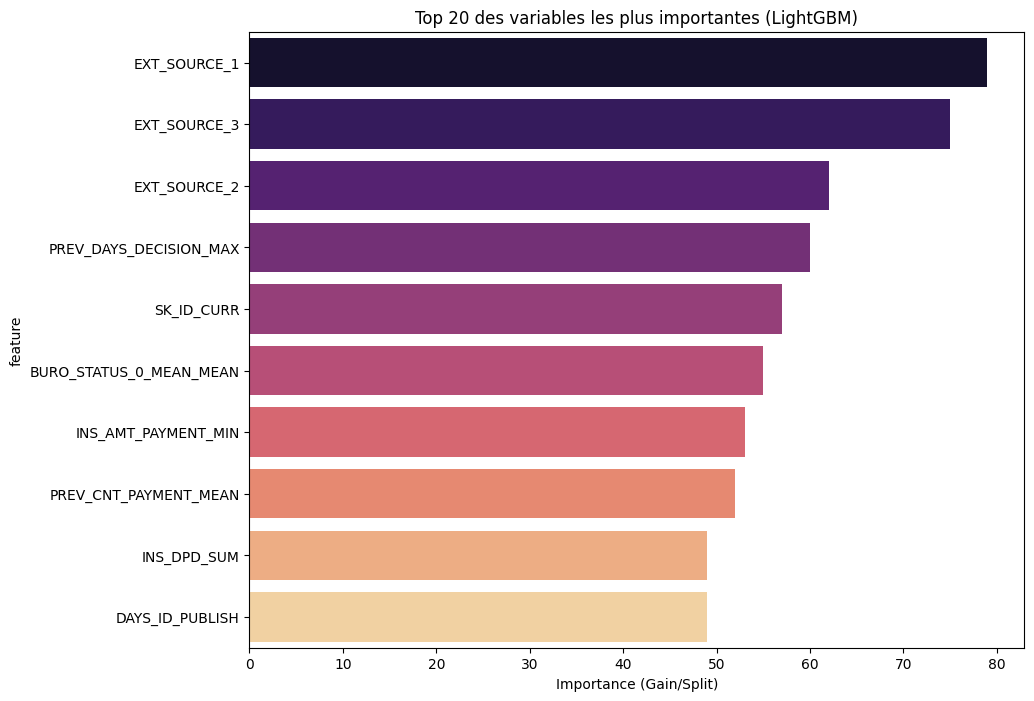

In [116]:
# Importance
# nettoie les noms des variables 
import re

def clean_column_names(df):
    # Cette regex remplace tout caractère non-alphanumérique par un underscore
    df.columns = [re.sub(r'[^\w\s]', '_', col) for col in df.columns]
    # Remplace aussi les espaces par des underscores
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

dataset_final.dropna(inplace = True,axis=0)

# Appliquez le nettoyage sur vos données d'entraînement
dataset_final = clean_column_names(dataset_final)
#X_test = clean_column_names(X_test)
y = dataset_final.TARGET
X = dataset_final.drop('TARGET',axis=1)

# importance
importance_results = plot_feature_importance(X, y)


/var/folders/dr/qtbb25gd2pl7ssnx51bqxv6r0000gp/T/ipykernel_3277/3421712485.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_results.head(10), palette='magma')


<Axes: xlabel='importance', ylabel='feature'>

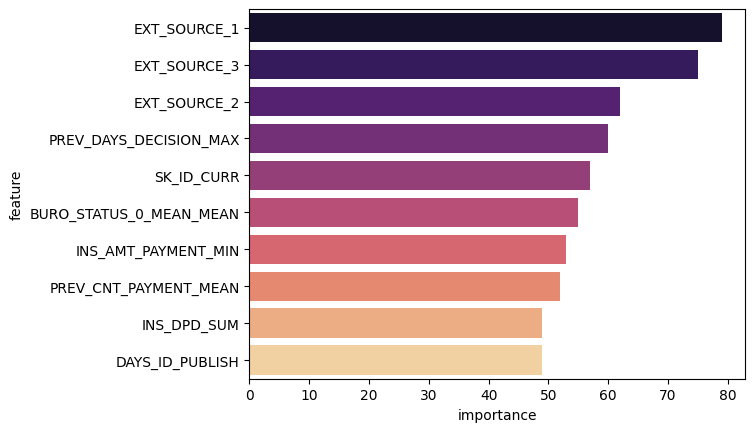

In [117]:
# Les 10 variables les plus importantes
sns.barplot(x='importance', y='feature', data=importance_results.head(10), palette='magma')

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.33,stratify=y,random_state=42)

=== ML train : MLFLOW === 


In [119]:
# On insere les contraintes métier
import numpy as np
from sklearn.metrics import confusion_matrix 

def optimize_threshold(y_true, y_probs):
    """
    Trouve le seuil qui minimise le coût métier : (10 * FN) + (1 * FP).
    
    y_true : les vraies étiquettes (0 ou 1)
    y_probs : les probabilités prédites par le modèle (pour la classe 1)
    """
    thresholds = np.linspace(0, 1, 101)  # Teste 100 seuils de 0.0 à 1.0
    costs = []
    
    for thr in thresholds:
        # On transforme la probabilité en prédiction binaire selon le seuil
        y_pred = (y_probs >= thr).astype(int)
        
        # Calcul de la matrice de confusion
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calcul du coût métier (pondération 10 pour les faux négatifs)
        current_cost = (10 * fn) + (1 * fp)
        costs.append(current_cost)
    
    # Trouver l'index du coût minimum
    best_index = np.argmin(costs)
    best_threshold = thresholds[best_index]
    min_cost = costs[best_index]
    
    return best_threshold, min_cost


In [120]:
# initier une expérience : modèle de base 
import mlflow
import mlflow.lightgbm
from lightgbm import LGBMClassifier

# 1. Nommer l'expérience pour s'y retrouver dans l'UI
mlflow.set_experiment("Credit_Scoring_Optimization")

def train_with_mlflow(X_train, y_train, X_test, y_test, params):
    # On active l'autolog pour capturer les paramètres LightGBM automatiquement
    mlflow.lightgbm.autolog()
    
    with mlflow.start_run(run_name="LightGBM_Baseline"):
        # Ajout de tags pour l'organisation (recommandation de Michaël)
        mlflow.set_tag("model_type", "LGBM")
        mlflow.set_tag("data_version", "v1_300_features")
        
        # Entraînement
        clf = LGBMClassifier(**params)
        clf.fit(X_train, y_train)
        
        # Calcul des prédictions
        y_probs = clf.predict_proba(X_test)[:, 1]
        
        # 2. Utilisation de notre Score Métier (optimisation du seuil)
        best_thr, min_cost = optimize_threshold(y_test, y_probs)
        
        # 3. Log manuel des métriques spécifiques au métier
        mlflow.log_metric("business_score", min_cost)
        mlflow.log_param("optimal_threshold", best_thr)
        
        print(f"Run terminé. Score Métier : {min_cost:.4f} au seuil {best_thr}")

# Paramètres de test
lgbm_params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "class_weight": "balanced",
    "importance_type": "gain"
}


In [121]:
#run mlflow 
train_with_mlflow(X_train, y_train, X_test, y_test, lgbm_params)

2026/01/21 14:36:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mpaga/Desktop/OC/Projet6/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


[LightGBM] [Info] Number of positive: 122, number of negative: 1640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19007
[LightGBM] [Info] Number of data points in the train set: 1762, number of used features: 261
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

2026/01/21 14:37:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mpaga/Desktop/OC/Projet6/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 14:37:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/21 14:37:03 WARNING

Run terminé. Score Métier : 537.0000 au seuil 0.01
